<a href="https://colab.research.google.com/github/ArMOUNO/deep_learning_models/blob/Deep-Learning-project/MobileNet_transfer_learning_with_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='flower.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('flower.zip')
f.keys()
!unzip flower.zip


Streaming output truncated to the last 5000 lines.
  inflating: flower/0015/10078.jpg   
  inflating: flower/0015/1008.jpg    
  inflating: flower/0015/10083.jpg   
  inflating: flower/0015/10086.jpg   
  inflating: flower/0015/10087.jpg   
  inflating: flower/0015/1009.jpg    
  inflating: flower/0015/10092.jpg   
  inflating: flower/0015/10093.jpg   
  inflating: flower/0015/10095.jpg   
  inflating: flower/0015/10097.jpg   
  inflating: flower/0015/10100.jpg   
  inflating: flower/0015/10101.jpg   
  inflating: flower/0015/10102.jpg   
  inflating: flower/0015/10105.jpg   
  inflating: flower/0015/10110.jpg   
  inflating: flower/0015/10111.jpg   
  inflating: flower/0015/10112.jpg   
  inflating: flower/0015/10114.jpg   
  inflating: flower/0015/10118.jpg   
  inflating: flower/0015/10120.jpg   
  inflating: flower/0015/10122.jpg   
  inflating: flower/0015/10123.jpg   
  inflating: flower/0015/10124.jpg   
  inflating: flower/0015/10138.jpg   
  inflating: flower/0015/10139.jpg   

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.13.0


In [ ]:
dataset = '/content/flower'

#test_dir ='/content/BHDN'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='training',
                                                                 seed=66)
validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='validation',
                                                                 seed=66)
#test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
#                                                                shuffle=True,
#                                                                batch_size=BATCH_SIZE,
#                                                                image_size=IMG_SIZE)

Found 14400 files belonging to 24 classes.
Using 11520 files for training.
Found 14400 files belonging to 24 classes.
Using 2880 files for validation.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomContrast(factor=0.1),
     layers.RandomBrightness(factor=0.1),

        layers.RandomZoom(height_factor=0.1, width_factor=0.1),

        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),


     ]
)

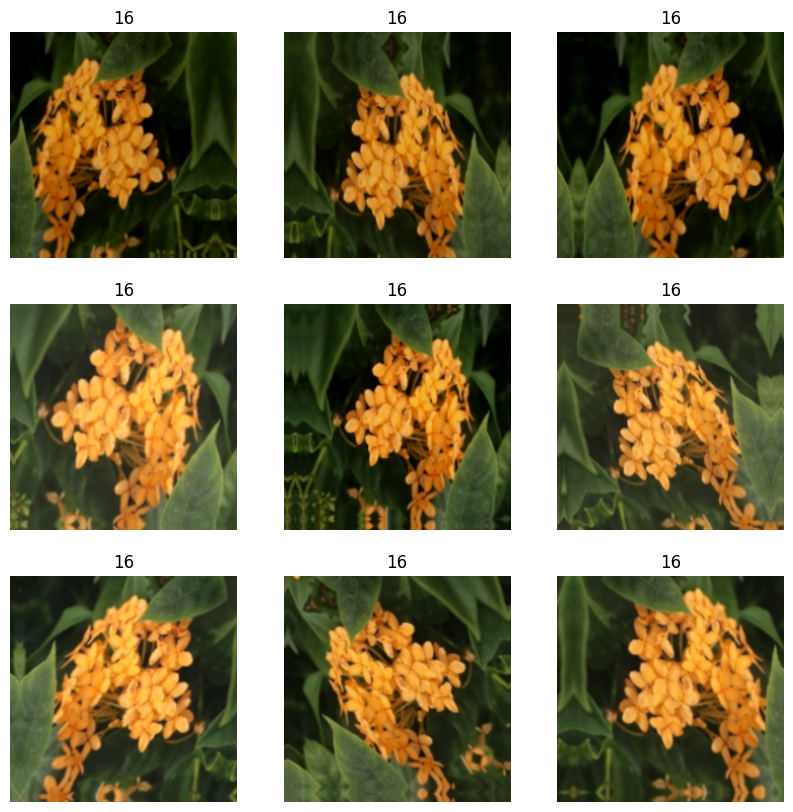

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.MobileNet (
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
nb_classes = 24
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)
outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

modelF = model

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
360/360 [==============================] - 42s 67ms/step - loss: 0.5121 - accuracy: 0.8503 - val_loss: 0.1725 - val_accuracy: 0.9469
Epoch 2/100
360/360 [==============================] - 21s 59ms/step - loss: 0.1930 - accuracy: 0.9392 - val_loss: 0.1207 - val_accuracy: 0.9618
Epoch 3/100
360/360 [==============================] - 22s 60ms/step - loss: 0.1438 - accuracy: 0.9538 - val_loss: 0.1225 - val_accuracy: 0.9587
Epoch 4/100
360/360 [==============================] - 22s 61ms/step - loss: 0.1259 - accuracy: 0.9561 - val_loss: 0.1163 - val_accuracy: 0.9639
Epoch 5/100
360/360 [==============================] - 22s 60ms/step - loss: 0.1129 - accuracy: 0.9593 - val_loss: 0.1163 - val_accuracy: 0.9649
Epoch 6/100
360/360 [==============================] - 22s 59ms/step - loss: 0.0993 - accuracy: 0.9649 - val_loss: 0.0803 - val_accuracy: 0.9733
Epoch 7/100
360/360 [==============================] - 22s 59ms/step - loss: 0.0890 - accuracy: 0.9689 - val_loss: 0.1134 - val_ac

In [ ]:
#scores = model.evaluate(test_dataset)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
modelF.trainable = True
modelF.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [ ]:
modelF.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

In [ ]:
epochs = 100
modelF.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
360/360 [==============================] - 72s 150ms/step - loss: 0.0627 - accuracy: 0.9788 - val_loss: 0.0592 - val_accuracy: 0.9812
Epoch 2/100
360/360 [==============================] - 54s 149ms/step - loss: 0.0531 - accuracy: 0.9807 - val_loss: 0.0507 - val_accuracy: 0.9830
Epoch 3/100
360/360 [==============================] - 54s 148ms/step - loss: 0.0450 - accuracy: 0.9833 - val_loss: 0.0510 - val_accuracy: 0.9823
Epoch 4/100
360/360 [==============================] - 53s 147ms/step - loss: 0.0402 - accuracy: 0.9848 - val_loss: 0.0542 - val_accuracy: 0.9816
Epoch 5/100
360/360 [==============================] - 54s 149ms/step - loss: 0.0359 - accuracy: 0.9867 - val_loss: 0.0638 - val_accuracy: 0.9833
Epoch 6/100
360/360 [==============================] - 53s 148ms/step - loss: 0.0339 - accuracy: 0.9868 - val_loss: 0.0532 - val_accuracy: 0.9837
Epoch 7/100
360/360 [==============================] - 54s 149ms/step - loss: 0.0343 - accuracy: 0.9875 - val_loss: 0.0440 -

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(modelF)
tflite_model = converter.convert()

with open("model1.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your Google Drive folder
drive_folder = '/content/drive/My Drive/flower/'

# Create the folder if it doesn't exist
import os
if not os.path.exists(drive_folder):
    os.makedirs(drive_folder)

# Path to save the TFLite model in your Google Drive folder
tflite_model_path = os.path.join(drive_folder, 'model.tflite')

# Save the TFLite model to the specified path
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'TFLite model saved to: {tflite_model_path}')


Mounted at /content/drive
TFLite model saved to: /content/drive/My Drive/flower/model.tflite


In [ ]:
#scores = modelF.evaluate(test_dataset)

In [ ]:
class_names = validation_dataset.class_names
class_names

['0000',
 '0001',
 '0002',
 '0003',
 '0004',
 '0005',
 '0006',
 '0007',
 '0008',
 '0009',
 '0010',
 '0011',
 '0012',
 '0013',
 '0014',
 '0015',
 '0016',
 '0017',
 '0018',
 '0019',
 '0020',
 '0021',
 '0022',
 '0023']

In [ ]:
def predict(modelF, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = modelF.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


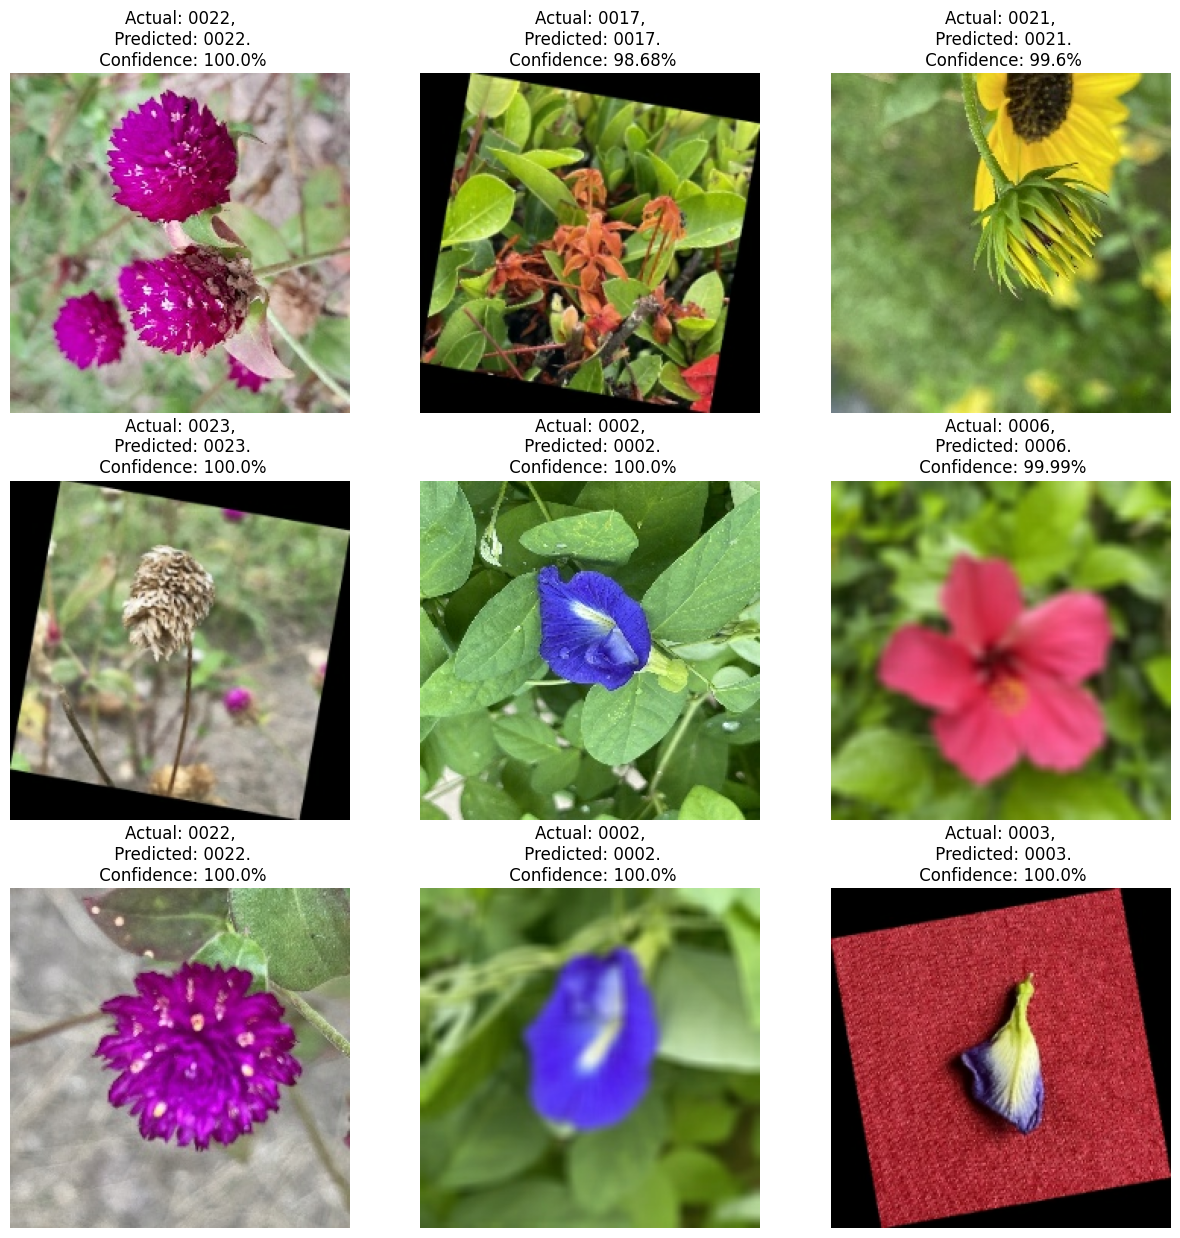

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(modelF, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 19ms/step


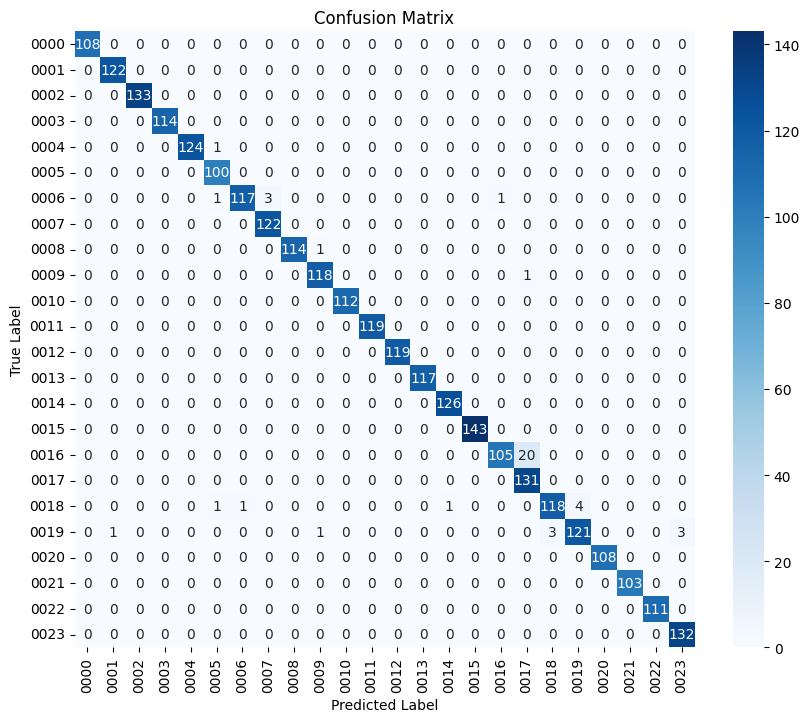

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in validation_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()